# Capstone Project - Seattle Car Accident Study
### Applied Data Science Capstone by Laurie Qian

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find correlation in several features which can lead to accurate prediction of severity of accidents. This can be used by municipal government agencies to publish more accurate guidelines to drivers on what to watch for, or even inform infrastructure planning committes to replan certain city intersections, or add additional sinage. The techniques and models which I will outline, can be reused and applied to any other city provided the data is pre-processed to fit the input vector shapes as shown below. 


In [3]:
import pandas as pd
import numpy as np

## Data <a name="data"></a>

We begin by reading the **Collisions.csv** file we were given. Based on an initial analysis of the data, we are given a data set of last 16 years of traffic accidents in Seattle metropolitan area. 

I will now group the data into useful columns. 

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Google Maps API reverse geocoding**
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of Berlin center will be obtained using **Google Maps API geocoding** of well known Berlin location (Alexanderplatz)

In [4]:
df = pd.read_csv('Collisions.csv')

This csv file contain the following columns

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                213918 non-null  float64
 1   Y                213918 non-null  float64
 2   OBJECTID         221389 non-null  int64  
 3   INCKEY           221389 non-null  int64  
 4   COLDETKEY        221389 non-null  int64  
 5   REPORTNO         221389 non-null  object 
 6   STATUS           221389 non-null  object 
 7   ADDRTYPE         217677 non-null  object 
 8   INTKEY           71884 non-null   float64
 9   LOCATION         216801 non-null  object 
 10  EXCEPTRSNCODE    100986 non-null  object 
 11  EXCEPTRSNDESC    11779 non-null   object 
 12  SEVERITYCODE     221388 non-null  object 
 13  SEVERITYDESC     221389 non-null  object 
 14  COLLISIONTYPE    195159 non-null  object 
 15  PERSONCOUNT      221389 non-null  int64  
 16  PEDCOUNT         221389 non-null  int6

Dumping the first few roles to get a sense of sample values.

In [6]:
df.head()

X          Y  OBJECTID  INCKEY  COLDETKEY   REPORTNO     STATUS  \
0 -122.320757  47.609408         1  328476     329976    EA08706    Matched   
1 -122.319561  47.662221         2  328142     329642    EA06882    Matched   
2 -122.327525  47.604393         3   20700      20700    1181833  Unmatched   
3 -122.327525  47.708622         4  332126     333626  M16001640  Unmatched   
4 -122.292120  47.559009         5  328238     329738    3857118  Unmatched   

  ADDRTYPE  INTKEY                                           LOCATION  ...  \
0    Block     NaN    BROADWAY BETWEEN E COLUMBIA ST AND BOYLSTON AVE  ...   
1    Block     NaN     8TH AVE NE BETWEEN NE 45TH E ST AND NE 47TH ST  ...   
2    Block     NaN               JAMES ST BETWEEN 6TH AVE AND 7TH AVE  ...   
3    Block     NaN  NE NORTHGATE WAY BETWEEN 1ST AVE NE AND NE NOR...  ...   
4    Block     NaN  M L KING JR ER WAY S BETWEEN S ANGELINE ST AND...  ...   

  ROADCOND                LIGHTCOND PEDROWNOTGRNT SDOTCOLNUM SPEEDING  \
0      Wet  Dark - Street Lights On           NaN        NaN      NaN   
1      Dry                 Daylight           NaN        NaN      NaN   
2      NaN                      NaN           NaN  4030032.0      NaN   
3      NaN                      NaN           NaN        NaN      NaN   
4      NaN                      NaN           NaN        NaN      NaN   

   ST_COLCODE                                         ST_COLDESC  SEGLANEKEY  \
0          11  From same direction - both going straight - bo...           0   
1          32                             One parked--one moving           0   
2         NaN                                                NaN           0   
3                                                            NaN           0   
4                                                            NaN           0   

   CROSSWALKKEY  HITPARKEDCAR  
0             0             N  
1             0             Y  
2             0             N  
3             0             N  
4             0             N  

[5 rows x 40 columns]

Next, I'm going to explore whether there are any correlation with the location of the most severe accidents and the neighborhoods. I've downloaded a geojson file from (here)[https://github.com/seattleio/seattle-boundaries-data/blob/master/data/neighborhoods.geojson] which describes boundaries of all seattle neighborhoods. 

In [7]:
import json

with open('neighborhoods.geojson') as json_file:
    neighborhoods = json.load(json_file)

def neighborhood_style(feature):
    return { 'color': 'blue', 'fill': False }

There are some rows with NaN or Null values for X, Y coordinates. Cleaning them.

In [8]:
df[['X','Y']].isna().sum()

X    7471
Y    7471
dtype: int64

In [9]:
df = df.dropna(axis=0, subset=['X','Y', 'SEVERITYCODE'])

Understanding which severity codes are there

In [10]:
df.value_counts('SEVERITYCODE')

SEVERITYCODE
1     133325
2      57675
0      19528
2b      3049
3        340
dtype: int64

According to Seattle Department of Transportation (SDOT), there are the following levels of severity, which matches the data dump from above.

1. Fatality collision (sdot code 3)

1. Serious injury collision (sdot code 2b)

1. Injury (sdot code 2)

1. Unknown (sdot code 0)

1. Property damage only collision (sdot code 1)


Plotting a heat map of the most severe accidents. 

In [11]:
import folium
from folium.plugins import HeatMap
from collections import defaultdict 

latitude = 47.6062
longitude = -122.3321
seattle_map = folium.Map(location = [latitude, longitude], zoom_start=13)

folium.TileLayer('cartodbpositron').add_to(seattle_map) #cartodbpositron cartodbdark_matter
folium.GeoJson(neighborhoods, style_function=neighborhood_style, name='geojson').add_to(seattle_map)

# build a look up table of lat lon collections by severity
severity_to_lat_lon = defaultdict(list)
for lat, lon, label, in zip(df.Y, df.X, df.SEVERITYCODE):
    severity_to_lat_lon[label].append([lat, lon])



In [12]:
# visualize accidents with severity code 3
HeatMap(severity_to_lat_lon['3']).add_to(seattle_map)

seattle_map

In [13]:
seattle_map.save("seattle_map.html")

From the heatmap we can see the most severe accidents seem to concentrate around First Hill, Ranier Valley and West Lake Union. Although there are also a lot of accidents seemingly spread all over the city. 

## Methodology <a name="methodology"></a>



I will now focus on understanding which features most directly correlate to accident severity. 

To avoid confirmation bias, I will first split the columns into the following groups: 

1. **reportable variables**: values known during accident reporting 

'X', 'Y', 'ADDRTYPE', 'COLLISIONTYPE', 'PERSONCOUNT','PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES','INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'HITPARKEDCAR'

2. **investigative variables**: values not known right away when reporting an accident

'SEVERITYCODE', 'SEVERITYDESC','SPEEDING','UNDERINFL', 'WEATHER', 'ROADCOND', 'INATTENTIONIND', 'FATALITIES', 'LIGHTCOND', 'PEDROWNOTGRNT',

3. **irrelevant variables**: administrative values, not useful for prediction

'OBJECTID', 'SDOT_COLCODE','ST_COLCODE','ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC','INTKEY', 'SDOT_COLDESC', 'SDOTCOLNUM',  'COLDETKEY', 'REPORTNO', 'STATUS', 'INCKEY', 'LOCATION'

Based on this, I will drop all irrelevant columns. Since the investigative variables also contain a lot of variables that can directly correlate to accident severity code, I will not use them in the prediction. 

I will now try to analyze the correlation of reportable variables with the one output variable which we will predict on, which is **SEVERITYCODE**. 

## Analysis <a name="analysis"></a>



Here are some basic exploratory analysis. 

In [14]:
df["INCDTTM"] = pd.to_datetime(df["INCDTTM"])
df["INCDTTM"]

0        2020-01-22 15:21:00
1        2020-01-07 08:00:00
2        2004-01-30 00:00:00
3        2016-01-23 00:00:00
4        2020-01-26 00:00:00
                 ...        
221384   2020-04-24 14:33:00
221385   2020-04-12 00:00:00
221386   2020-02-24 09:26:00
221387   2020-03-13 06:53:00
221388   2020-03-10 12:03:00
Name: INCDTTM, Length: 213917, dtype: datetime64[ns]

In [15]:
df["COLLISIONTYPE"].value_counts()

Parked Car    46931
Angles        35341
Rear Ended    33553
Other         23126
Sideswipe     18312
Left Turn     14031
Pedestrian     7600
Cycles         5886
Right Turn     2969
Head On        2151
Name: COLLISIONTYPE, dtype: int64

<AxesSubplot:xlabel='INCDTTM'>

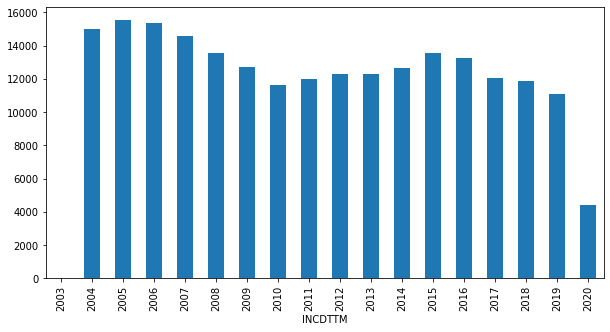

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Group accident per year
df.groupby([df['INCDTTM'].dt.year])['INCDTTM'].count().plot(kind='bar',figsize=(10,5),legend= None )

<AxesSubplot:xlabel='INCDTTM'>

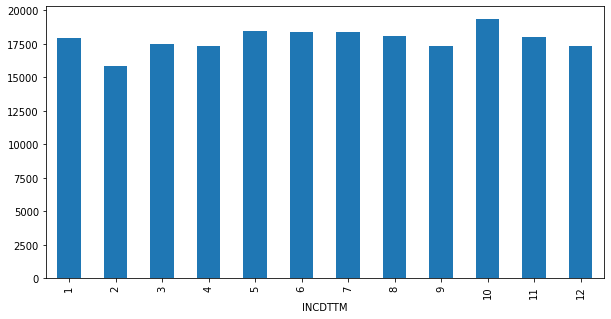

In [17]:
# Group accident per months
df.groupby([df['INCDTTM'].dt.month])['INCDTTM'].count().plot(kind='bar',figsize=(10,5),legend= None )

<AxesSubplot:xlabel='INCDTTM'>

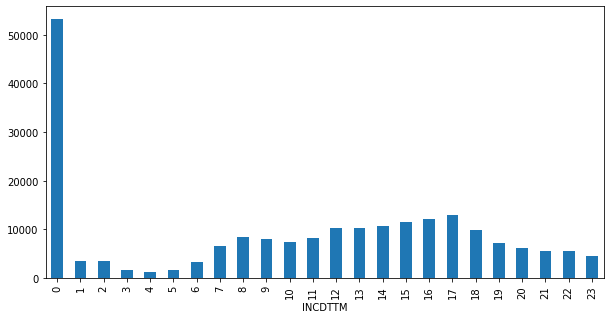

In [18]:
# Group accident per hour
df.groupby([df['INCDTTM'].dt.hour])['INCDTTM'].count().plot(kind='bar',figsize=(10,5),legend= None )

Seems like midnight is a big outlier for accidents. Rate of accidents also seems to increase steadily after noon each day, peaks at 5pm which is during rush hour. Let's now look at accident severity per hour. Let's store hour in the dataframe. Let's look at if this can be used to predict accident severity. 

In [19]:
df['hour'] = df['INCDTTM'].dt.hour

Text(0.5, 1.0, 'Number of accidents per hour of day')

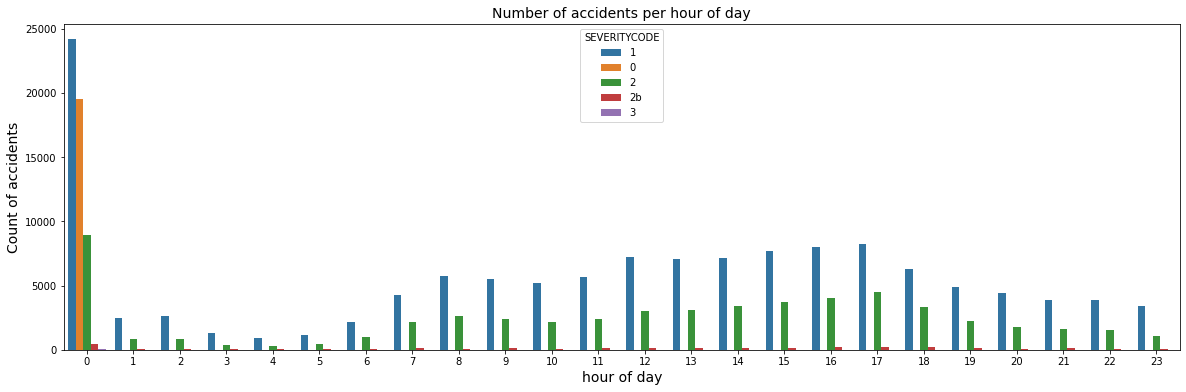

In [20]:

plt.figure(figsize=(20,6))

ax = sns.countplot(x = 'hour', data = df, hue = 'SEVERITYCODE')
plt.xlabel("hour of day", size=14)
plt.ylabel("Count of accidents", size=14)
plt.title("Number of accidents per hour of day", fontsize = 14)

With this, hour of day doesn't seem correlated to severity of accident, but rather if there will be an accident or not. Let's look at other correlations. 

In [21]:
input_df = df[['SEVERITYCODE', 'ADDRTYPE', 'COLLISIONTYPE', 'PERSONCOUNT','PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES','hour', 'JUNCTIONTYPE', 'HITPARKEDCAR']]
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213917 entries, 0 to 221388
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   SEVERITYCODE     213917 non-null  object
 1   ADDRTYPE         213917 non-null  object
 2   COLLISIONTYPE    189900 non-null  object
 3   PERSONCOUNT      213917 non-null  int64 
 4   PEDCOUNT         213917 non-null  int64 
 5   PEDCYLCOUNT      213917 non-null  int64 
 6   VEHCOUNT         213917 non-null  int64 
 7   INJURIES         213917 non-null  int64 
 8   SERIOUSINJURIES  213917 non-null  int64 
 9   hour             213917 non-null  int64 
 10  JUNCTIONTYPE     205727 non-null  object
 11  HITPARKEDCAR     213917 non-null  object
dtypes: int64(7), object(5)
memory usage: 31.2+ MB


We need to one-hot encode some of the columns. 

In [22]:
dummy_cols = ['ADDRTYPE', 'COLLISIONTYPE', 'JUNCTIONTYPE', 'HITPARKEDCAR']
final_df = pd.get_dummies(input_df, columns=dummy_cols)
final_df.dropna(inplace=True)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213917 entries, 0 to 221388
Data columns (total 29 columns):
 #   Column                                                          Non-Null Count   Dtype 
---  ------                                                          --------------   ----- 
 0   SEVERITYCODE                                                    213917 non-null  object
 1   PERSONCOUNT                                                     213917 non-null  int64 
 2   PEDCOUNT                                                        213917 non-null  int64 
 3   PEDCYLCOUNT                                                     213917 non-null  int64 
 4   VEHCOUNT                                                        213917 non-null  int64 
 5   INJURIES                                                        213917 non-null  int64 
 6   SERIOUSINJURIES                                                 213917 non-null  int64 
 7   hour                                           

Text(0.5, 1.0, 'Correlation Matrix')

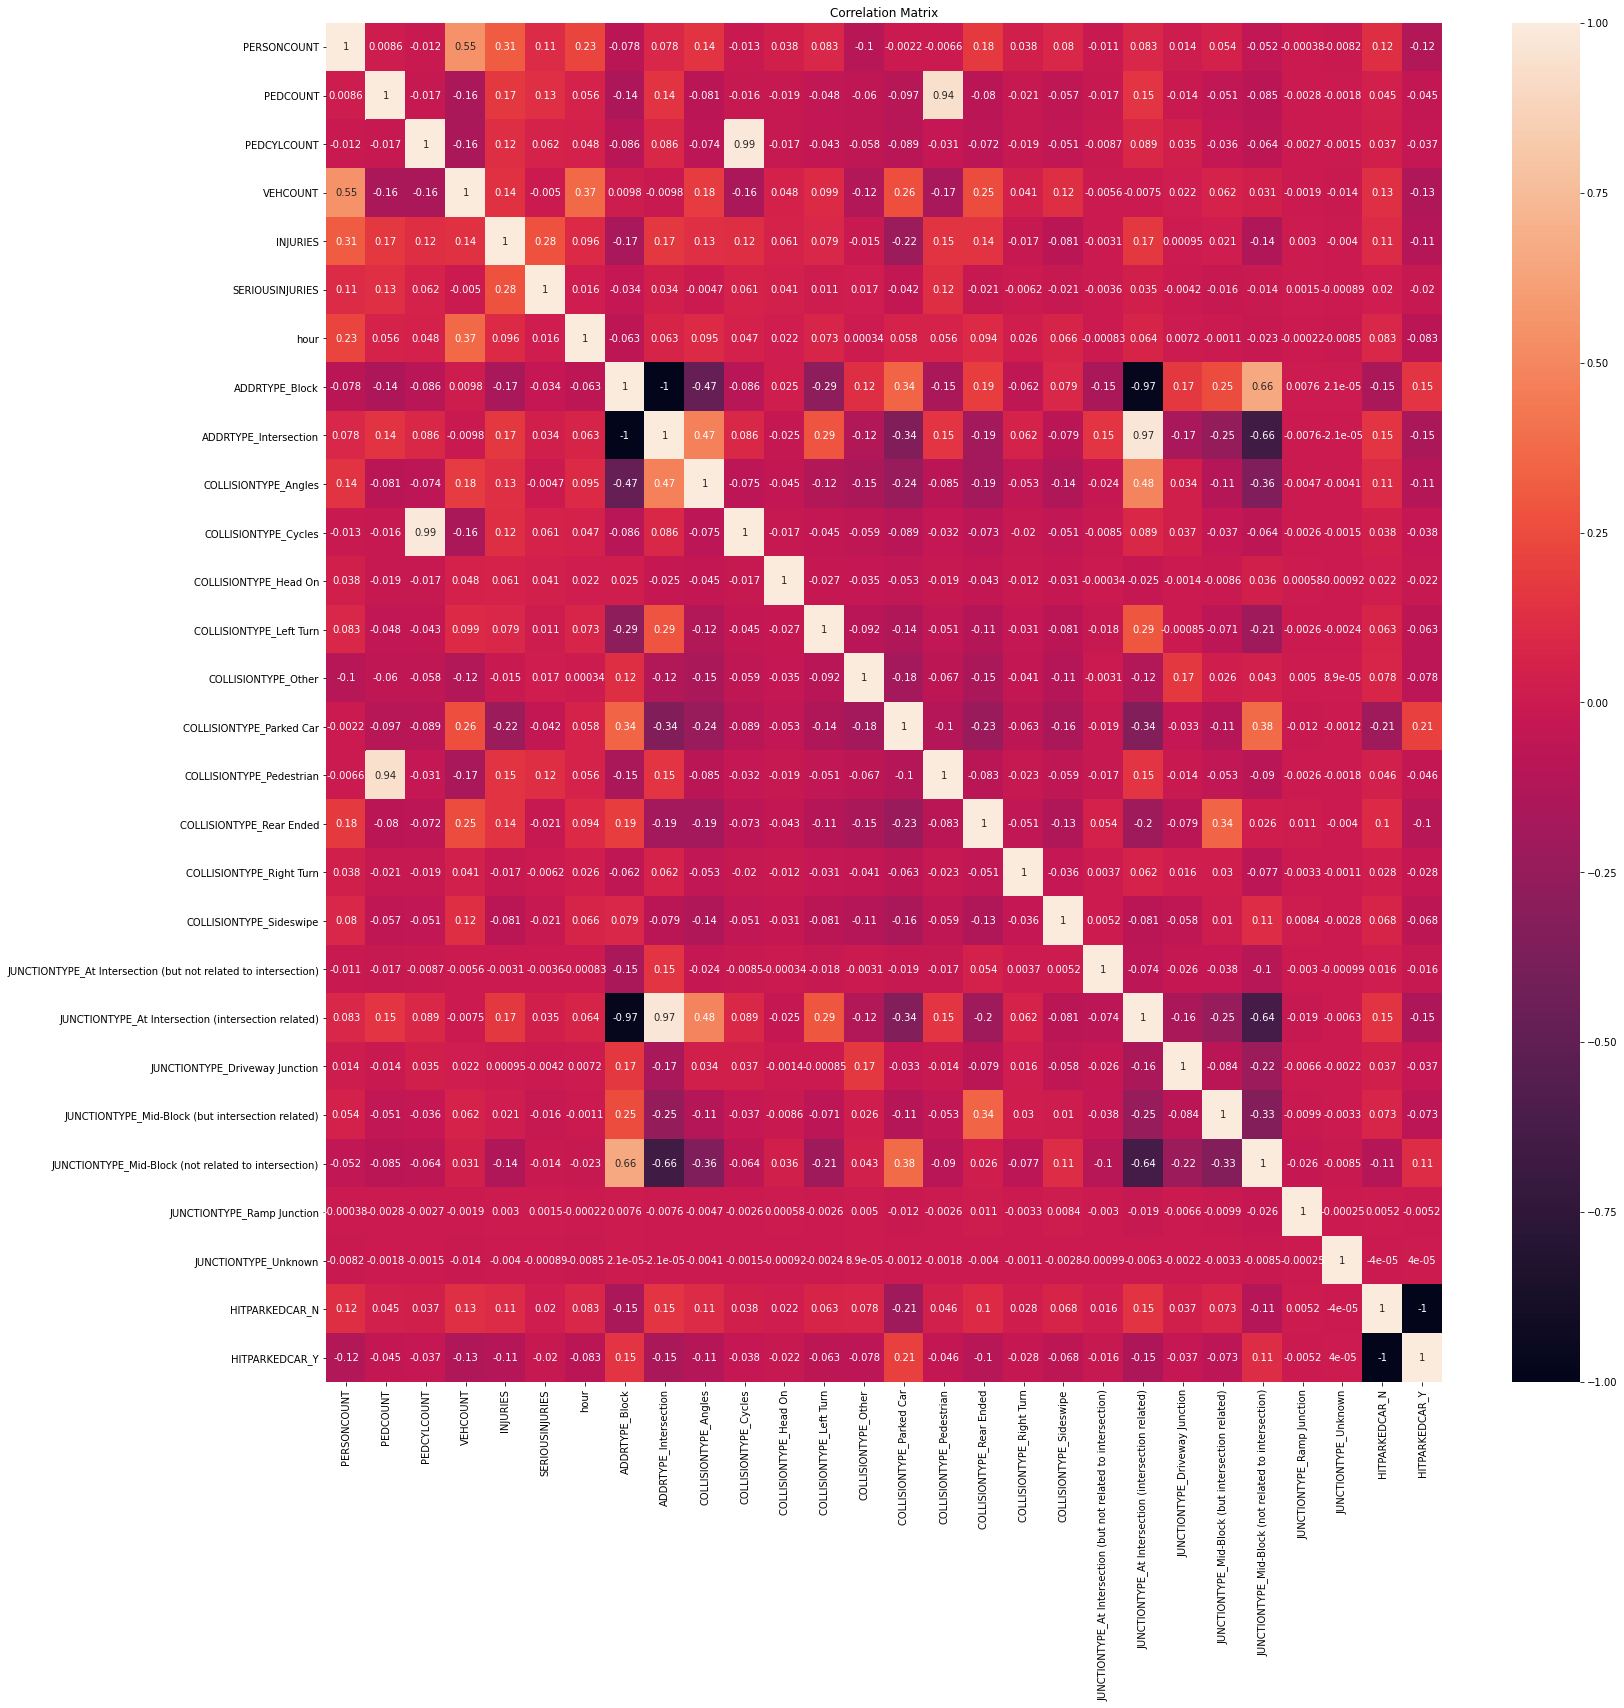

In [23]:
hm = final_df.corr()
plt.subplots(figsize=(25,25))
ax = sns.heatmap(hm, annot=True)
ax.set_title('Correlation Matrix')

No surprise, vehicle count is strongly correlated to people count, injuries is also strongly correlated to person count. Injuries is also correlated to series injuries but only lightly. Now let's prepare the output variable for regression. 

In [24]:
df['SEVERITYCODE'] = df['SEVERITYCODE'].map({'1': 1, '2': 2, '2b': 3, '3': 4})

In [25]:
from sklearn import preprocessing
y = final_df['SEVERITYCODE']
X = final_df.drop(columns='SEVERITYCODE', axis=1)
scaled = preprocessing.StandardScaler().fit(X).transform(X)
scaled[0:5]

array([[-0.17051648, -0.19149825, -0.16861437,  0.30988452, -0.51630767,
        -0.09678023,  0.64342598,  0.70879823, -0.70879823, -0.44486462,
        -0.16820779, -0.10078412, -0.26494341, -0.34815394, -0.53013914,
        -0.19192842, -0.43131121, -0.11863625,  3.2683013 , -0.10792555,
        -0.68871901, -0.2371595 , -0.35585392,  1.07918854, -0.0277835 ,
        -0.00917343,  0.24026625, -0.24026625],
       [-0.17051648, -0.19149825, -0.16861437,  0.30988452, -0.51630767,
        -0.09678023, -0.2946949 ,  0.70879823, -0.70879823, -0.44486462,
        -0.16820779, -0.10078412, -0.26494341, -0.34815394,  1.88629723,
        -0.19192842, -0.43131121, -0.11863625, -0.30596934, -0.10792555,
        -0.68871901, -0.2371595 , -0.35585392,  1.07918854, -0.0277835 ,
        -0.00917343, -4.1620494 ,  4.1620494 ],
       [-1.53376247, -0.19149825, -0.16861437, -2.1310009 , -0.51630767,
        -0.09678023, -1.36683305,  0.70879823, -0.70879823, -0.44486462,
        -0.16820779, -0.1007

In [26]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled, y, test_size=0.2, random_state = 4)


In [27]:
# Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion='entropy', max_depth=4)
dtree.fit(X_train, y_train)
dtree_yhat = dtree.predict(X_test)
print(classification_report(y_test, dtree_yhat))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3873
           1       0.99      1.00      0.99     26735
           2       1.00      1.00      1.00     11538
          2b       0.99      0.98      0.99       561
           3       0.00      0.00      0.00        77

    accuracy                           0.99     42784
   macro avg       0.79      0.79      0.79     42784
weighted avg       0.99      0.99      0.99     42784



In [28]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=75)
rfc.fit(X_train, y_train)
rfc_yhat = rfc.predict(X_test)
print(classification_report(y_test, rfc_yhat))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3873
           1       0.99      1.00      0.99     26735
           2       1.00      1.00      1.00     11538
          2b       0.99      0.98      0.99       561
           3       0.11      0.01      0.02        77

    accuracy                           0.99     42784
   macro avg       0.81      0.79      0.79     42784
weighted avg       0.99      0.99      0.99     42784



In [29]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01)
LR.fit(X_train, y_train)
LR_yhat = LR.predict(X_test)
print(classification_report(y_test, LR_yhat))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      3873
           1       0.99      0.99      0.99     26735
           2       1.00      1.00      1.00     11538
          2b       0.99      0.97      0.98       561
           3       0.00      0.00      0.00        77

    accuracy                           0.99     42784
   macro avg       0.78      0.78      0.78     42784
weighted avg       0.99      0.99      0.99     42784



## Results and Discussion <a name="results"></a>

Using the input variables of 'ADDRTYPE', 'COLLISIONTYPE', 'PERSONCOUNT','PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES','hour', 'JUNCTIONTYPE', 'HITPARKEDCAR'. We are able to predict the severity of an accident with 0.99 accuracy with Decision Tree Classifier, RandomForestClassifier, as well as LogisticRegression. 

## Conclusion <a name="conclusion"></a>

When accidents are reported, first responders and traffic control are welcome to use the models trained in this notebook to predict the severity of the accident. I hope this may benefit the community. 